In [1]:
import numpy as np
import torch

from torch_geometric.datasets import Planetoid
from torch_geometric.data.collate import collate

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import networkx as nx
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [2]:
data = Planetoid(root="dataset_graph", name="Cora")
data

Cora()

In [3]:
data[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [4]:
# Investigating the dataset
print("Dataset type: ", type(data))
  ############# Your code here ############

### !!! We will consider all graphs as UNDIRECTED !!! ###


print("This database contains ", data.len(), " graphs")
print("Each node of each of the graphs contains ", data.num_node_features, " features")
print("This dataset is separated in ", data.num_classes, " classes")
print()

### We are going to display the information of FIRST GRAPH IN DATASET at the beginning
### after that We are going to display the information of ENTIRE DATASET

### FIRST GRAPH informations

print("The number of FIRST GRAPH nodes IN DATASET: ", data[0].num_nodes)
"""
because of the fact that We want to consider all graphs as undirected 
and in the definition of graph, there are two edges for each edge, 
we divide the output of function in 2
"""
print("The number of FIRST GRAPH edges IN DATASET: ", data[0].num_edges/2)
print("The average of FIRST GRAPH node degree IN DATASET: ", data[0].num_edges/data[0].num_nodes)
print()

### ENTIRE DATASET informations

# First approach for finding the number of all nodes and edges
# It is used a loop for Investigating each Graph
num_nodes_list = []
num_edges_list = []
for grp in data:
    num_nodes_list.append(grp.num_nodes)
    num_edges_list.append(grp.num_edges / 2)
print("The number of total nodes: ", sum(num_nodes_list), "  First approach")
print("The number of total edges: ", sum(num_edges_list), "  First approach")
print("The average of total node degree: ", (2*sum(num_edges_list) / sum(num_nodes_list)), "  First approach")
print()

# Second approach for finding the number of all nodes and edges
# we will merge each data which is a graph in this dataset, together as one huge Graph
# in other word we consider all graphs as one huge graph
huge_data, slices, _ = collate(
                    data[0].__class__, 
                    data_list=data, 
                    increment=False, 
                    add_batch=False, 
                    )
print("The huge graph which include all subgraphs: ", huge_data)
print("Each node of this graph contains", huge_data.num_node_features, "features")

print("The number of total nodes: ", huge_data.num_nodes, "  Second approach")

"""
because of the fact that We want to consider all graphs as undirected 
and in the definition of graph, there are two edges for each edge, 
we divide the output of function in 2
"""

print("The number of total edges: ", huge_data.num_edges / 2, "  Second approach")
print("The average of total node degree: ", huge_data.num_edges / huge_data.num_nodes, "  Second approach")
print()


  #########################################

# edge_index = graph connections
# smiles = molecule with its atoms
# x = node features (32 nodes have each 9 features)
# y = labels (dimension)

Dataset type:  <class 'torch_geometric.datasets.planetoid.Planetoid'>
This database contains  1  graphs
Each node of each of the graphs contains  1433  features
This dataset is separated in  7  classes

The number of FIRST GRAPH nodes IN DATASET:  2708
The number of FIRST GRAPH edges IN DATASET:  5278.0
The average of FIRST GRAPH node degree IN DATASET:  3.8980797636632203

The number of total nodes:  2708   First approach
The number of total edges:  5278.0   First approach
The average of total node degree:  3.8980797636632203   First approach

The huge graph which include all subgraphs:  Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Each node of this graph contains 1433 features
The number of total nodes:  2708   Second approach
The number of total edges:  5278.0   Second approach
The average of total node degree:  3.8980797636632203   Second approach



In [5]:
# This function is used to display the node level GNN results
def plot_history(list_train_loss, list_train_acc, list_val_loss, list_val_acc, n_epochs, title):
    
    plt.figure(figsize=(12,6),linewidth = 7, edgecolor="whitesmoke")    
    # plot accuracy and loss for train dataset
    plt.plot(list(range(1, n_epochs+1)), list_train_acc, color='orange',marker=".")
    plt.plot(list(range(1, n_epochs+1)), list_train_loss, color='b', marker=".")
    # plot accuracy and loss for validation dataset
    plt.plot(list(range(1, n_epochs+1)), list_val_acc,'r')  
    plt.plot(list(range(1, n_epochs+1)), list_val_loss,'g')
    
    plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
    plt.grid(True)
    

    plt.xlabel("Number of Epochs")
    plt.ylabel("Value")
    plt.suptitle(title, size=16, y=0.927)
    plt.show()

In [6]:
# using t-SNE for displaying
def visualize(embs, color, title):
    xs, ys = zip(*TSNE().fit_transform(embs.detach().numpy()))

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(xs, ys, s=25, c=color, cmap="Set2")
    plt.title('Visualization using 2-componenet of TSNE / '+ title)
    plt.show()

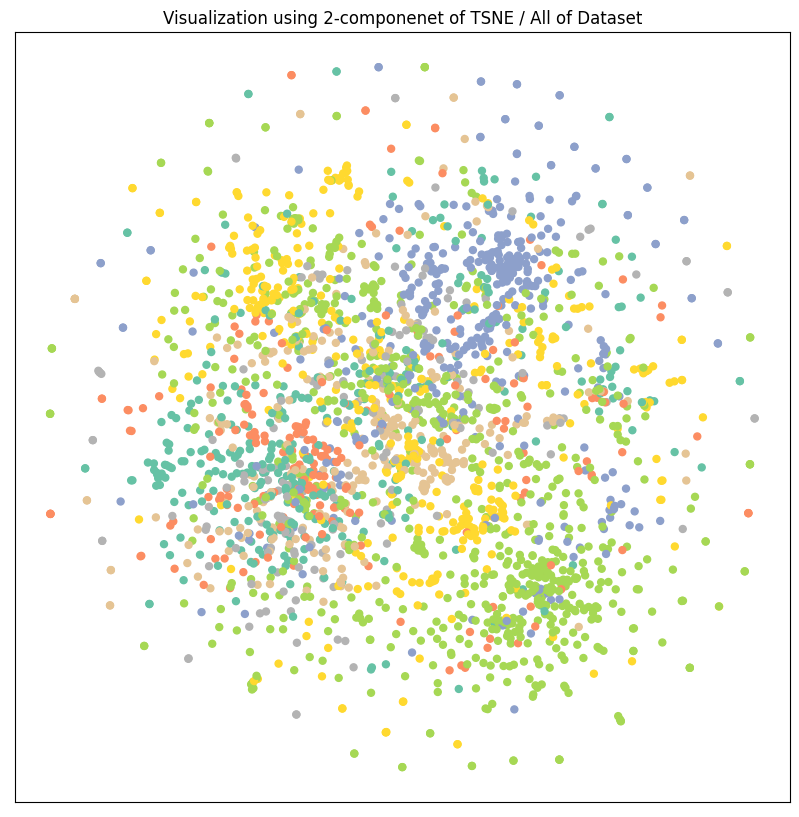

In [7]:
visualize(data[0].x, color=data[0].y, title = "All of Dataset")

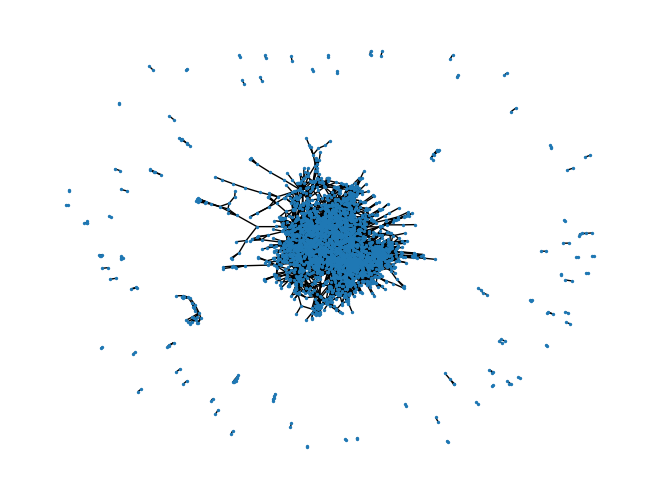

In [8]:
# Displaying Graph
G= to_networkx(data[0], to_undirected=True)
nx.draw(G, with_labels=False, node_size=2, width=1, font_size=1) 

In [9]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [10]:
class GCN_node(torch.nn.Module):
    def __init__(self, num_layers, feature_dim, embed_dim, output_dim):
      
        super().__init__()
        self.num_layers = num_layers
        # self.convs stores a list of GCN layers of length self.num_layers
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(feature_dim, embed_dim))
        for _ in range(self.num_layers - 1):
            self.convs.append(GCNConv(embed_dim, embed_dim))
        # we will have used self.classifier after we will found embeddings
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(embed_dim, embed_dim), torch.nn.Dropout(0.25), 
            torch.nn.Linear(embed_dim, output_dim))
    # We will design our neural network in forward
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # if there is no feature, we will use 1 as all nodes
        if data.num_node_features == 0:
            x = torch.ones(data.num_nodes, 1)
        # 1.finding embeds
        for i in range(self.num_layers -1):
            x = self.convs[i](x, edge_index)
            x = F.tanh(x)
            x = F.dropout(x, p=0.5, training=self.training)
        embed = self.convs[-1](x, edge_index)
        # 2.classification 
        class_vec = self.classifier(embed)
        return embed, class_vec

In [11]:
class Leaning_Evaluation_node(torch.nn.Module):
    def __init__(
        self,
        data,
        model,
        learning_rate=0.01,
        n_epochs=100,
        ):
        super().__init__()
        self.data = data
        self.model = model
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.criterion = torch.nn.CrossEntropyLoss()
        self.n_epochs = n_epochs
        
    # This method do train step for each epoch
    def train_one_epoch(self):
        # start training model
        self.model.train()
        # initial optimizer is zero
        self.optimizer.zero_grad()
        # Forward Propagation
        _, out = self.model(self.data)
        # Compute loss for train and validation dataset
        train_loss = self.criterion(out[self.data.train_mask], self.data.y[self.data.train_mask])
        validation_loss = self.criterion(out[self.data.val_mask], data.y[self.data.val_mask])
        # Compute Accuracy for train and validation dataset
        pred = out.argmax(dim=1)
        train_correct = pred[self.data.train_mask] == self.data.y[self.data.train_mask]
        train_acc = int(train_correct.sum()) / int(self.data.train_mask.sum())
        validation_correct = pred[self.data.val_mask] == data.y[self.data.val_mask]
        validation_acc = int(validation_correct.sum()) / int(self.data.val_mask.sum())
        # Backward Propagation
        train_loss.backward()
        # Optimaze NN weights
        self.optimizer.step()
        return train_loss, train_acc, validation_loss, validation_acc

    def train(self):
        # Lists to display results
        list_train_loss, list_train_acc, list_val_loss, list_val_acc = [], [], [], []
        # call train step for each epoch and print results
        for epoch in range(1, self.n_epochs+1):
            train_loss, train_acc, validation_loss, validation_acc = self.train_one_epoch()
            list_train_loss.append(float(train_loss.detach()))
            list_train_acc.append(train_acc)
            list_val_loss.append(float(validation_loss.detach()))
            list_val_acc.append(validation_acc)
            print(f'Epoch: {epoch:03d}, Trian Loss: {train_loss:.4f}, Trian Accuracy: {train_acc:.4f}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_acc:.4f}')
        
        return list_train_loss, list_train_acc, list_val_loss, list_val_acc
    
    # This method predicts inputs
    def test(self):
        self.model.eval()
        _, out = self.model(self.data)
        test_loss = self.criterion(out[self.data.test_mask], self.data.y[self.data.test_mask])
        pred = out.argmax(dim=1)
        test_correct = pred[data.test_mask] == self.data.y[self.data.test_mask]
        test_acc = int(test_correct.sum()) / int(self.data.test_mask.sum())
        return test_acc, test_loss

In [12]:
# Use CPU for processing
device = torch.device('cpu')
data_set = data[0].to(device)

In [13]:
# make and display model
gcn_model = GCN_node(num_layers=3, feature_dim=data.num_node_features, embed_dim=32, output_dim=7)
print(gcn_model)

GCN_node(
  (convs): ModuleList(
    (0): GCNConv(1433, 32)
    (1-2): 2 x GCNConv(32, 32)
  )
  (classifier): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): Dropout(p=0.25, inplace=False)
    (2): Linear(in_features=32, out_features=7, bias=True)
  )
)


In [14]:
evaluate_GCN = Leaning_Evaluation_node(data=data_set,
                                   model = gcn_model,
                                   learning_rate=0.01,
                                   n_epochs=15,
                                   )
list_train_loss, list_train_acc, list_val_loss, list_val_acc = evaluate_GCN.train()

Epoch: 001, Trian Loss: 1.9525, Trian Accuracy: 0.1500, Validation Loss: 1.9684, Validation Accuracy: 0.1360
Epoch: 002, Trian Loss: 1.8909, Trian Accuracy: 0.3000, Validation Loss: 1.9200, Validation Accuracy: 0.2120
Epoch: 003, Trian Loss: 1.7817, Trian Accuracy: 0.6143, Validation Loss: 1.8566, Validation Accuracy: 0.4160
Epoch: 004, Trian Loss: 1.6057, Trian Accuracy: 0.6929, Validation Loss: 1.7454, Validation Accuracy: 0.5300
Epoch: 005, Trian Loss: 1.3793, Trian Accuracy: 0.7500, Validation Loss: 1.6131, Validation Accuracy: 0.6000
Epoch: 006, Trian Loss: 1.0783, Trian Accuracy: 0.7857, Validation Loss: 1.4128, Validation Accuracy: 0.6360
Epoch: 007, Trian Loss: 0.8778, Trian Accuracy: 0.7857, Validation Loss: 1.2547, Validation Accuracy: 0.6540
Epoch: 008, Trian Loss: 0.6631, Trian Accuracy: 0.8214, Validation Loss: 1.2028, Validation Accuracy: 0.6220
Epoch: 009, Trian Loss: 0.4690, Trian Accuracy: 0.8643, Validation Loss: 1.1317, Validation Accuracy: 0.6600
Epoch: 010, Trian L

In [15]:
test_acc, test_loss = evaluate_GCN.test()
print(f'Test Accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}')

Test Accuracy: 0.7620, Test loss: 1.2949


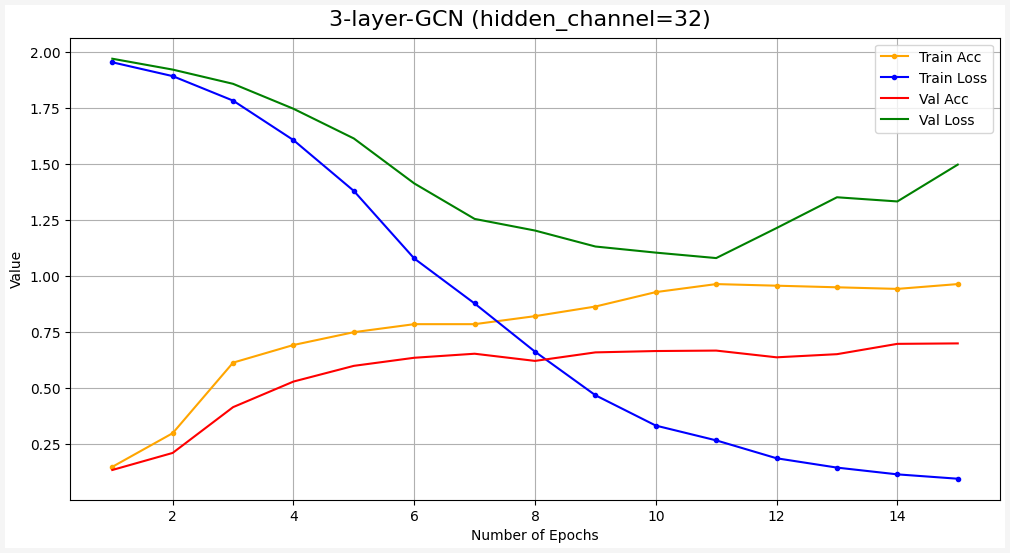

In [16]:
plot_history(list_train_loss, list_train_acc, list_val_loss, list_val_acc, evaluate_GCN.n_epochs, title='3-layer-GCN (hidden_channel=32)')

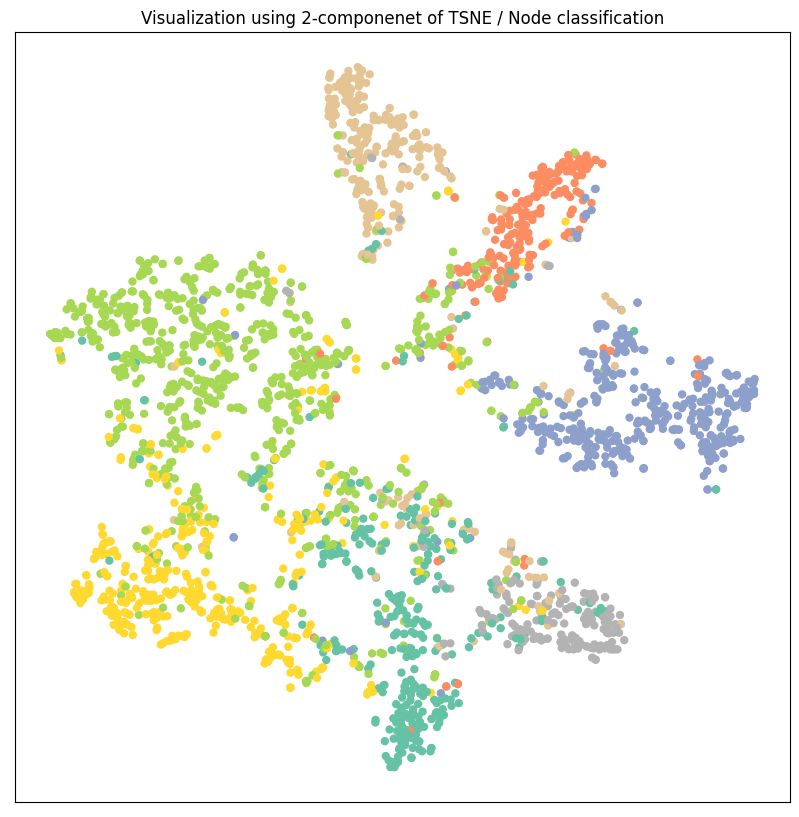

In [17]:
model = evaluate_GCN.model
model.eval()
embde, _ = model(data)
visualize(embde, color=data.y, title='Node classification')

In [18]:
from torch_geometric.datasets import TUDataset

In [19]:
# Like Spektral, pytorch geometric provides us with benchmark TUDatasets
dataset = TUDataset(root='data/TUDataset', name='PROTEINS')

In [20]:
# Let's take a look at our data. We'll look at dataset (all data) and data (our first graph):

data = dataset[0]  # Get the first graph object.

print()
print(f'Dataset: {dataset}:')
print('====================')
# How many graphs?
print(f'Number of graphs: {len(dataset)}')
# How many features?
print(f'Number of features: {dataset.num_features}')
# Now, in our first graph, how many edges?
print(f'Number of edges: {data.num_edges}')
# Average node degree?
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# Do we have isolated nodes?
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
# Do we contain self-loops?
print(f'Contains self-loops: {data.has_self_loops()}')
# Is this an undirected graph?
print(f'Is undirected: {data.is_undirected()}')


Dataset: PROTEINS(1113):
Number of graphs: 1113
Number of features: 3
Number of edges: 162
Average node degree: 3.86
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [21]:
# Now, we need to perform our train/test split.
# We create a seed, and then shuffle our data
torch.manual_seed(12345)
dataset = dataset.shuffle()

# Once it's shuffled, we slice the data to split
train_dataset = dataset[150:-150]
test_dataset = dataset[0:150]

# Take a look at the training versus test graphs
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 813
Number of test graphs: 150


In [22]:
# Import DataLoader for batching
# A data loader which merges data objects from a torch_geometric.data.Dataset to a mini-batch. 
# Data objects can be either of type Data or HeteroData.
from torch_geometric.loader import DataLoader

# our DataLoader creates diagonal adjacency matrices, and concatenates features
# and target matrices in the node dimension. This allows differing numbers of nodes and edges 
# over examples in one batch. (from pytorch geometric docs)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [23]:
from torch_geometric.nn import global_mean_pool

class GCN_graph(torch.nn.Module):
    def __init__(self, num_layers, feature_dim, embed_dim, output_dim):
      
        super().__init__()
        self.num_layers = num_layers
        # self.convs stores a list of GCN layers of length self.num_layers
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(feature_dim, embed_dim))
        for _ in range(self.num_layers - 1):
            self.convs.append(GCNConv(embed_dim, embed_dim))
        # we will have used self.classifier after we will found embeddings
        self.classifier = torch.nn.Linear(embed_dim, output_dim)
    # We will design our neural network in forward
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # if there is no feature, we will use 1 as all nodes
        if data.num_node_features == 0:
            x = torch.ones(data.num_nodes, 1)
        # 1. Obtain node embeddings 
        for i in range(self.num_layers -1):
            x = self.convs[i](x, edge_index)
            x = x.relu()
        node_embed = self.convs[-1](x, edge_index)
        # 2. Obtain node embeddings using global_mean_pool
        graph_embed = global_mean_pool(node_embed, batch)
        # 3. Apply a final classifier
        class_vec = self.classifier(graph_embed)

        return graph_embed, class_vec

In [24]:
# make and display model
gcn_model = GCN_graph(num_layers=3, feature_dim=dataset.num_node_features, embed_dim=64, output_dim=dataset.num_classes)
print(gcn_model)

GCN_graph(
  (convs): ModuleList(
    (0): GCNConv(3, 64)
    (1-2): 2 x GCNConv(64, 64)
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


In [25]:

class Leaning_Evaluation_graph(torch.nn.Module):
    def __init__(
        self,
        train_data,
        test_data,
        model,
        learning_rate=0.01,
        n_epochs=200,
        ):
        super().__init__()
        self.train_loader = train_data
        self.test_loader = test_data
        self.model = model
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.criterion = torch.nn.CrossEntropyLoss()
        self.n_epochs = n_epochs
        
    # This method do train step for each epoch    
    def train_one_epoch(self):
        self.model.train()
        for data in train_loader:  # Iterate in batches over the training dataset.
            self.optimizer.zero_grad() # Clear gradients.
            _, out = self.model(data)  # Perform a single forward pass.
            loss = self.criterion(out, data.y)  # Compute the loss.
            loss.backward()  # Derive gradients.
            self.optimizer.step()  # Update parameters based on gradients.
            

    # Define our test function
    def test(self, loader):
        self.model.eval()
        correct = 0
        for data in loader:  # Iterate in batches over the training/test dataset.
            _, out = self.model(data)  
            pred = out.argmax(dim=1)  # Use the class with highest probability.
            correct += int((pred == data.y).sum())  # Check against ground-truth labels.
        return correct / len(loader.dataset)  # Derive ratio of correct predictions.


    def train(self):
        # Lists to display results
        list_train_acc = []
        list_test_acc = []
        # call train step for each epoch and print results
        for epoch in range(1, self.n_epochs+1):
            self.train_one_epoch()
            train_acc = self.test(train_loader)
            list_train_acc.append(train_acc)
            test_acc = self.test(test_loader)
            list_test_acc.append(test_acc)
            print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        return list_train_acc, list_test_acc
      

In [26]:
evaluate_GCN = Leaning_Evaluation_graph(train_data = train_loader,
                                   test_data = test_loader,
                                   model = gcn_model,
                                   learning_rate=0.01,
                                   n_epochs=200,
                                   )
train_accuracy, test_accuracy = evaluate_GCN.train()

Epoch: 001, Train Acc: 0.5904, Test Acc: 0.6000
Epoch: 002, Train Acc: 0.6494, Test Acc: 0.6400
Epoch: 003, Train Acc: 0.6396, Test Acc: 0.6733
Epoch: 004, Train Acc: 0.6962, Test Acc: 0.7067
Epoch: 005, Train Acc: 0.6691, Test Acc: 0.6867
Epoch: 006, Train Acc: 0.6519, Test Acc: 0.6867
Epoch: 007, Train Acc: 0.7097, Test Acc: 0.7267
Epoch: 008, Train Acc: 0.7060, Test Acc: 0.7267
Epoch: 009, Train Acc: 0.6728, Test Acc: 0.6867
Epoch: 010, Train Acc: 0.6765, Test Acc: 0.7000
Epoch: 011, Train Acc: 0.7073, Test Acc: 0.7267
Epoch: 012, Train Acc: 0.6950, Test Acc: 0.7267
Epoch: 013, Train Acc: 0.6765, Test Acc: 0.7067
Epoch: 014, Train Acc: 0.7183, Test Acc: 0.7267
Epoch: 015, Train Acc: 0.6753, Test Acc: 0.6800
Epoch: 016, Train Acc: 0.6839, Test Acc: 0.7133
Epoch: 017, Train Acc: 0.7171, Test Acc: 0.7200
Epoch: 018, Train Acc: 0.6937, Test Acc: 0.7200
Epoch: 019, Train Acc: 0.6986, Test Acc: 0.7133
Epoch: 020, Train Acc: 0.7060, Test Acc: 0.7133
Epoch: 021, Train Acc: 0.6900, Test Acc:

In [27]:
# This function is used to display the graph level GNN results
def plot_history_graph(list_train_acc, list_test_acc, n_epochs, title):
    
    plt.figure(figsize=(12,6),linewidth = 7, edgecolor="whitesmoke")    
    
    plt.plot(list(range(1, n_epochs+1)), list_train_acc, color='orange',marker=".")
    plt.plot(list(range(1, n_epochs+1)), list_test_acc, color='blue', marker=".")
    
    plt.legend(['Train Acc','Test Acc'])
    plt.grid(True)
    
    plt.xlabel("Number of Epochs")
    plt.ylabel("Value")
    plt.suptitle(title, size=16, y=0.927)
    plt.show()

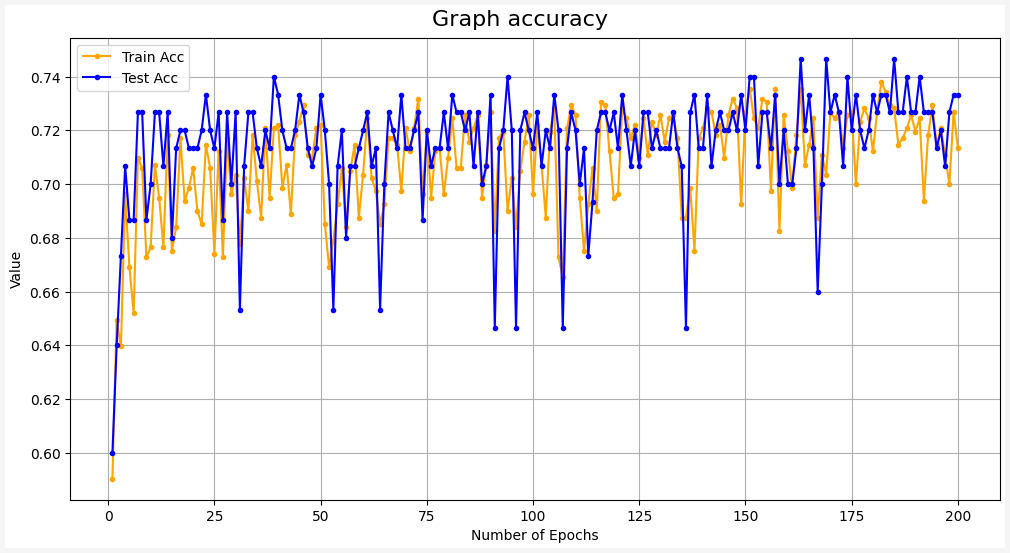

In [28]:
plot_history_graph(train_accuracy, test_accuracy, 200, "Graph accuracy")

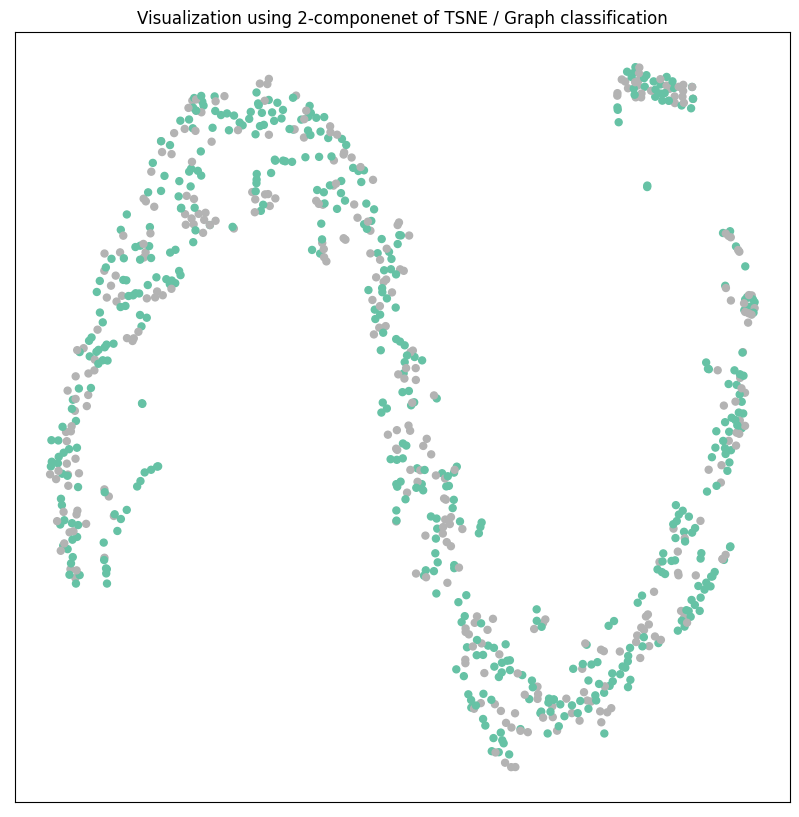

In [29]:
###! بخش امتیازی !###
# using t-SNE for displaying

train_loader_as_one = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
model = evaluate_GCN.model
model.eval()
for data in train_loader_as_one:
    embde, _ = model(data)
visualize(embde, color=train_dataset.y, title='Graph classification')